In [2]:
pip install sqlalchemy psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [9]:
# Loading the Data

import os
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
from sqlalchemy import create_engine

PROJECT_ROOT = Path.cwd()
load_dotenv(PROJECT_ROOT / ".env")

host = os.getenv("DB_HOST", "localhost")
port = os.getenv("DB_PORT", "5432")
db = os.getenv("DB_NAME", "superstore")
user = os.getenv("DB_USER", "superstore_user")
pwd = os.getenv("DB_PASSWORD", "REDACTED")

engine = create_engine(f"postgresql+psycopg2://{user}:{pwd}@{host}:{port}/{db}")

df = pd.read_sql("SELECT * FROM processed_superstore;", engine)
df.shape, df.head()


((9994, 17),
    id  raw_id       ship_mode    segment        country             city  \
 0   1       1    Second Class   Consumer  United States        Henderson   
 1   2       2    Second Class   Consumer  United States        Henderson   
 2   3       3    Second Class  Corporate  United States      Los Angeles   
 3   4       4  Standard Class   Consumer  United States  Fort Lauderdale   
 4   5       5  Standard Class   Consumer  United States  Fort Lauderdale   
 
         state postal_code region         category sub_category     sales  \
 0    Kentucky       42420  South        Furniture    Bookcases  261.9600   
 1    Kentucky       42420  South        Furniture       Chairs  731.9400   
 2  California       90036   West  Office Supplies       Labels   14.6200   
 3     Florida       33311  South        Furniture       Tables  957.5775   
 4     Florida       33311  South  Office Supplies      Storage   22.3680   
 
    quantity  discount    profit  profit_margin            

## Data Preparation for EDA

### Dropping Identifier Columns (`id`, `raw_id`)

The columns `id` and `raw_id` were removed from the dataset before analysis.

**Reasoning:**
- These columns are technical identifiers used for database management.
- They do not carry analytical or predictive value.
- Keeping them may introduce noise or misleading relationships during EDA and modeling.

Therefore, they were excluded to keep the dataset focused on meaningful business features.


In [10]:
df_eda = df.drop(columns=["id", "raw_id"])
df_eda.head()


,ship_mode,segment,country,city,state,postal_code,region,category,sub_category,sales,quantity,discount,profit,profit_margin,processed_at
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136,0.1600,2026-01-27 05:28:06.674225
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820,0.3000,2026-01-27 05:28:06.674225
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714,0.4700,2026-01-27 05:28:06.674225
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310,-0.4000,2026-01-27 05:28:06.674225
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164,0.1125,2026-01-27 05:28:06.674225


### Feature Engineering: Profit Margin

A new feature called `profit_margin` was added during the processing stage.
  
**Definition:**
profit_margin = profit / sales

**Why this feature exists:**
- Absolute profit alone does not provide a fair comparison across orders.
- Profit margin normalizes profit relative to sales size.
- It helps evaluate how efficient each sale is, regardless of order value.

This feature is commonly used in retail analytics and will be useful for:
- Exploratory analysis
- Understanding loss-making orders
- Potential machine learning modeling


## Exploratory Data Analysis (EDA)

This section explores the processed dataset to:
- Understand data distributions
- Identify anomalies or outliers
- Validate business logic assumptions
- Prepare insights for modeling

We start with basic sanity checks and summary statistics.


In [11]:
df_eda.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ship_mode      9994 non-null   object        
 1   segment        9994 non-null   object        
 2   country        9994 non-null   object        
 3   city           9994 non-null   object        
 4   state          9994 non-null   object        
 5   postal_code    9994 non-null   object        
 6   region         9994 non-null   object        
 7   category       9994 non-null   object        
 8   sub_category   9994 non-null   object        
 9   sales          9994 non-null   float64       
 10  quantity       9994 non-null   int64         
 11  discount       9994 non-null   float64       
 12  profit         9994 non-null   float64       
 13  profit_margin  9994 non-null   float64       
 14  processed_at   9994 non-null   datetime64[ns]
dtypes: datetime64[ns](1),

In [12]:
df_eda.describe()

,sales,quantity,discount,profit,profit_margin,processed_at
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994
mean,229.857901,3.789574,0.156203,28.656599,0.120310,2026-01-27 05:28:06.674224384
min,0.444000,1.000000,0.000000,-6599.978000,-2.750000,2026-01-27 05:28:06.674225
25%,17.280000,2.000000,0.000000,1.728750,0.075000,2026-01-27 05:28:06.674224896
50%,54.490000,3.000000,0.200000,8.666500,0.270000,2026-01-27 05:28:06.674224896
75%,209.940000,5.000000,0.200000,29.364000,0.362500,2026-01-27 05:28:06.674224896
max,22638.480000,14.000000,0.800000,8399.976000,0.500000,2026-01-27 05:28:06.674225
std,623.245124,2.225110,0.206452,234.260115,0.466752,NaN


## Dataset Columns Description

The dataset contains transactional sales data enriched during the processing stage.

- **id**: Internal database primary key (not used for analysis)
- **raw_id**: Reference to the original raw record for traceability
- **ship_mode**: Shipping method used for the order
- **segment**: Customer segment (Consumer, Corporate, Home Office)
- **country**: Country of the customer
- **city**: Customer city
- **state**: Customer state
- **postal_code**: Postal code (categorical identifier)
- **region**: Sales region
- **category**: High-level product category
- **sub_category**: Detailed product sub-category
- **sales**: Total sales value of the order
- **quantity**: Number of units sold
- **discount**: Discount applied to the order
- **profit**: Net profit of the order
- **profit_margin**: Derived feature representing profit relative to sales
- **processed_at**: Timestamp of data processing


In [13]:
# Basic numerical overview
num_cols = ["sales", "profit", "profit_margin", "discount", "quantity"]
df_eda[num_cols].describe()


,sales,profit,profit_margin,discount,quantity
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,229.857901,28.656599,0.120310,0.156203,3.789574
std,623.245124,234.260115,0.466752,0.206452,2.225110
min,0.444000,-6599.978000,-2.750000,0.000000,1.000000
25%,17.280000,1.728750,0.075000,0.000000,2.000000
50%,54.490000,8.666500,0.270000,0.200000,3.000000
75%,209.940000,29.364000,0.362500,0.200000,5.000000
max,22638.480000,8399.976000,0.500000,0.800000,14.000000


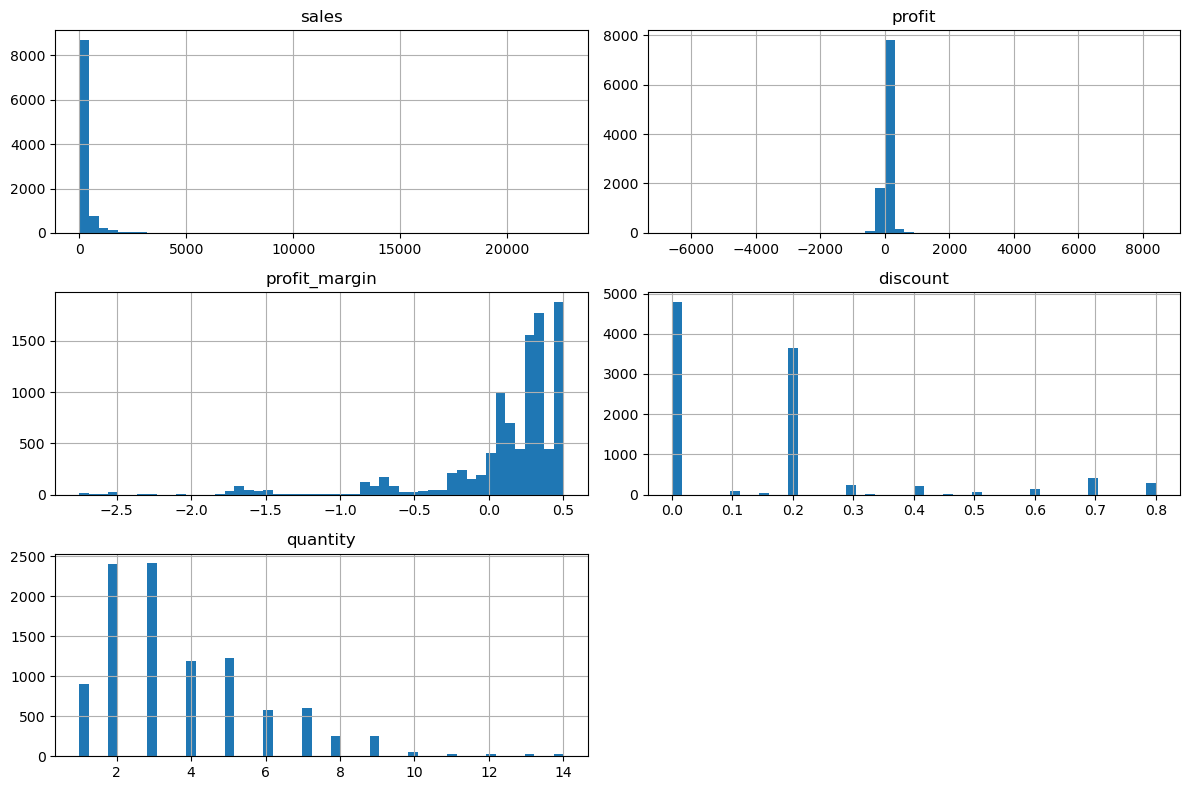

In [14]:
import matplotlib.pyplot as plt

# Histograms to inspect distributions and potential outliers
df_eda[num_cols].hist(bins=50, figsize=(12,8))
plt.tight_layout()
plt.show()


In [15]:
# Profit statistics by category
df_eda.groupby("category")["profit"].describe()


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Furniture,2121.0,8.699327,136.049246,-1862.3124,-12.84900,7.7748,33.7266,1013.127
Office Supplies,6026.0,20.327050,164.887280,-3701.8928,2.10150,6.8824,19.4163,4946.370
Technology,1847.0,78.750394,428.816844,-6599.9780,5.20365,25.0182,74.8946,8399.976


In [16]:
# Profit statistics by segment
df_eda.groupby("segment")["profit"].describe()


,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
Consumer,5191.0,25.836301,242.594028,-6599.9780,1.58355,8.3754,28.60670,6719.9808
Corporate,3020.0,30.456667,231.986266,-3839.9904,1.92840,8.6940,29.84350,8399.9760
Home Office,1783.0,33.818664,212.381482,-3399.9800,1.98425,9.1020,31.55985,3919.9888


In [17]:
import matplotlib.pyplot as plt

profit_by_category = (
    df_eda
    .groupby("category", as_index=False)["profit"]
    .sum()
    .sort_values("profit", ascending=False)
)

profit_by_category


,category,profit
2,Technology,145451.9773
1,Office Supplies,122490.8008
0,Furniture,18451.2728


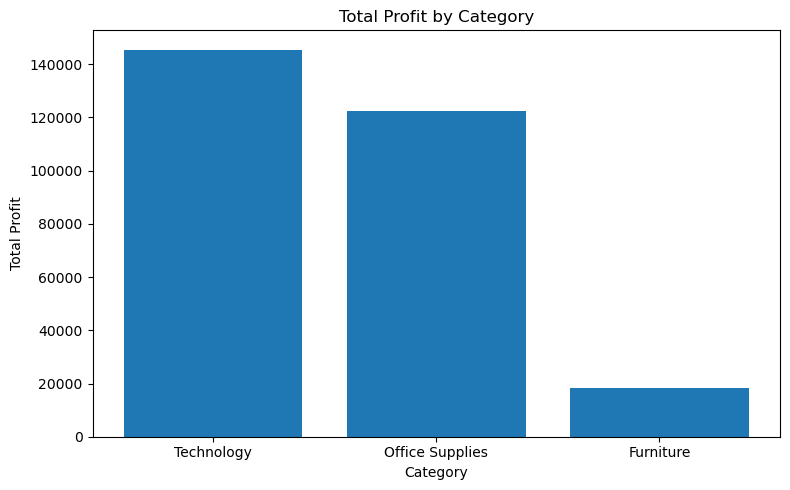

In [19]:
# Create a figure with specified size (8 inches width, 5 inches height)
plt.figure(figsize=(8,5))
plt.bar(profit_by_category["category"], profit_by_category["profit"])
plt.title("Total Profit by Category")
plt.xlabel("Category")
plt.ylabel("Total Profit")
plt.tight_layout()

# Display the chart
plt.show()


In [20]:
profit_by_subcat = (
    df_eda
    .groupby("sub_category", as_index=False)["profit"]
    .sum()
    .sort_values("profit", ascending=False)
)

profit_by_subcat.head(10)


,sub_category,profit
6,Copiers,55617.8249
13,Phones,44513.7306
0,Accessories,41935.6649
12,Paper,34053.5693
3,Binders,30221.7633
5,Chairs,26590.1663
14,Storage,21278.8264
1,Appliances,18138.0054
9,Furnishings,13059.1436
7,Envelopes,6964.1767


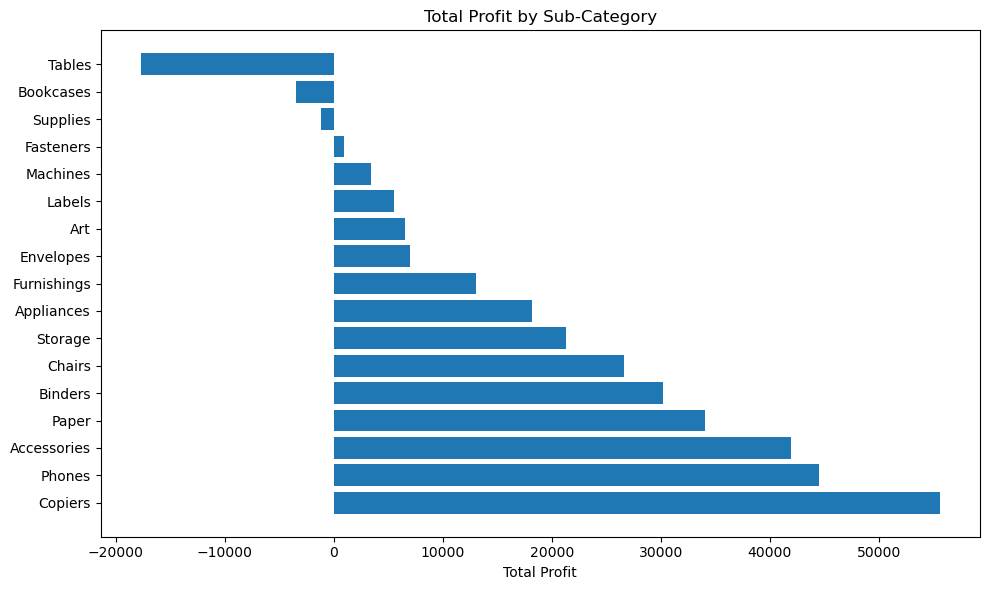

In [21]:
plt.figure(figsize=(10,6))
plt.barh(profit_by_subcat["sub_category"], profit_by_subcat["profit"])
plt.title("Total Profit by Sub-Category")
plt.xlabel("Total Profit")
plt.tight_layout()
plt.show()


In [22]:
profit_by_segment = (
    df_eda
    .groupby("segment", as_index=False)["profit"]
    .sum()
    .sort_values("profit", ascending=False)
)

profit_by_segment


,segment,profit
0,Consumer,134116.2384
1,Corporate,91979.1340
2,Home Office,60298.6785


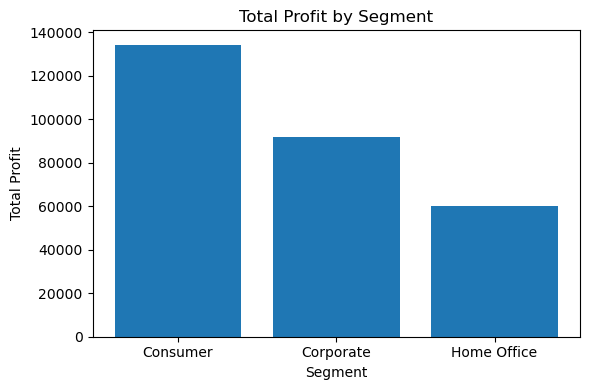

In [23]:
plt.figure(figsize=(6,4))
plt.bar(profit_by_segment["segment"], profit_by_segment["profit"])
plt.title("Total Profit by Segment")
plt.xlabel("Segment")
plt.ylabel("Total Profit")
plt.tight_layout()
plt.show()


In [24]:
pivot_cat_seg = pd.pivot_table(
    df_eda,
    values="profit",
    index="category",
    columns="segment",
    aggfunc="sum"
)

pivot_cat_seg


segment,Consumer,Corporate,Home Office
category,,,
Furniture,6991.0786,7584.8158,3875.3784
Office Supplies,56330.3210,40227.3202,25933.1596
Technology,70794.8388,44166.9980,30490.1405


In [29]:
df_eda["discount_bin"] = pd.cut(
    df_eda["discount"],
    bins=[-0.01, 0, 0.2, 0.4, 0.6, 1.0],
    labels=["0", "0-20%", "20-40%", "40-60%", "60%+"]
)

profit_by_discount = (
    df_eda
    .groupby("discount_bin", as_index=False, observed=True)["profit"]
    .mean()
)

profit_by_discount


,discount_bin,profit
0,0,66.899673
1,0-20%,26.501571
2,20-40%,-77.864055
3,40-60%,-134.624160
4,60%+,-98.348741


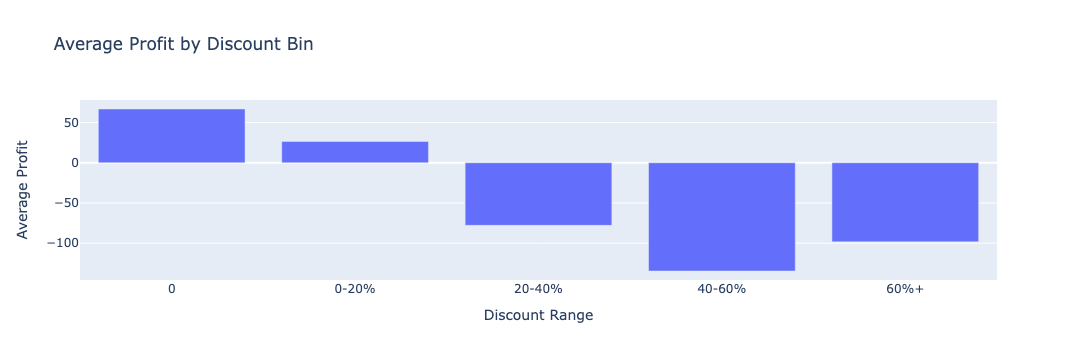

In [33]:
import plotly.express as px

fig = px.bar(
    profit_by_discount,
    x="discount_bin",
    y="profit",
    labels={
        "profit": "Average Profit",
        "discount_bin": "Discount Range"
    },
    title="Average Profit by Discount Bin"
)

fig.show()


In [34]:
profit_by_category = (
    df_eda
    .groupby("category", as_index=False)["profit"]
    .mean()
)

profit_by_category


,category,profit
0,Furniture,8.699327
1,Office Supplies,20.327050
2,Technology,78.750394


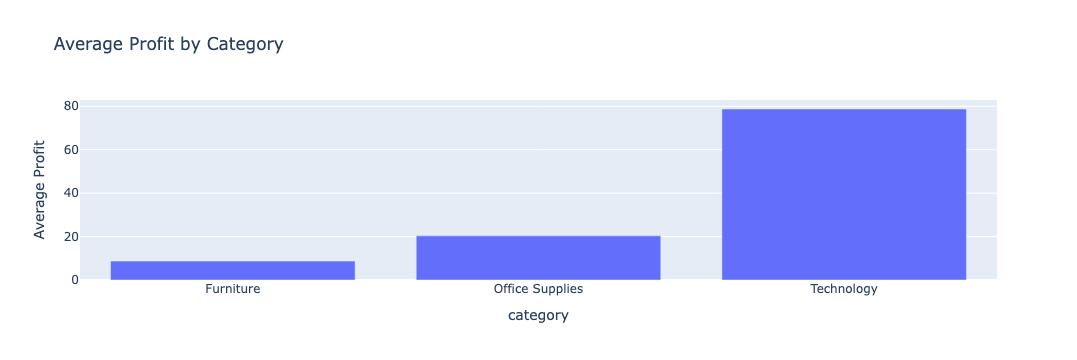

In [35]:
fig = px.bar(
    profit_by_category,
    x="category",
    y="profit",
    labels={"profit": "Average Profit"},
    title="Average Profit by Category"
)
fig.show()


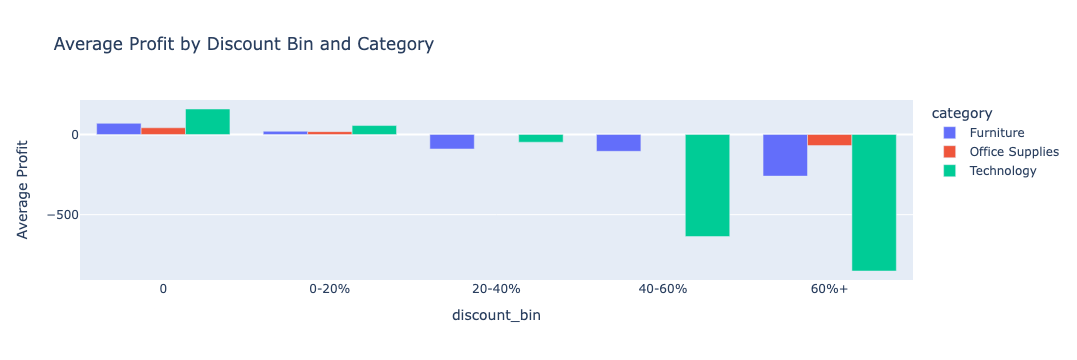

In [38]:
cat_discount_profit = (
    df_eda
    .groupby(
        ["category", "discount_bin"],
        as_index=False,
        observed=True
    )["profit"]
    .mean()
)

fig = px.bar(
    cat_discount_profit,
    x="discount_bin",
    y="profit",
    color="category",
    barmode="group",
    labels={"profit": "Average Profit"},
    title="Average Profit by Discount Bin and Category"
)
fig.show()


In [39]:
seg_discount_profit = (
    df_eda
    .groupby(
        ["segment", "discount_bin"],
        as_index=False,
        observed=True
    )["profit"]
    .mean()
)

seg_discount_profit


,segment,discount_bin,profit
0,Consumer,0,64.160500
1,Consumer,0-20%,24.113989
2,Consumer,20-40%,-69.070467
3,Consumer,40-60%,-115.738709
4,Consumer,60%+,-110.617372
5,Corporate,0,71.584290
6,Corporate,0-20%,25.233687
7,Corporate,20-40%,-94.522012
8,Corporate,40-60%,-152.983339
9,Corporate,60%+,-79.307147


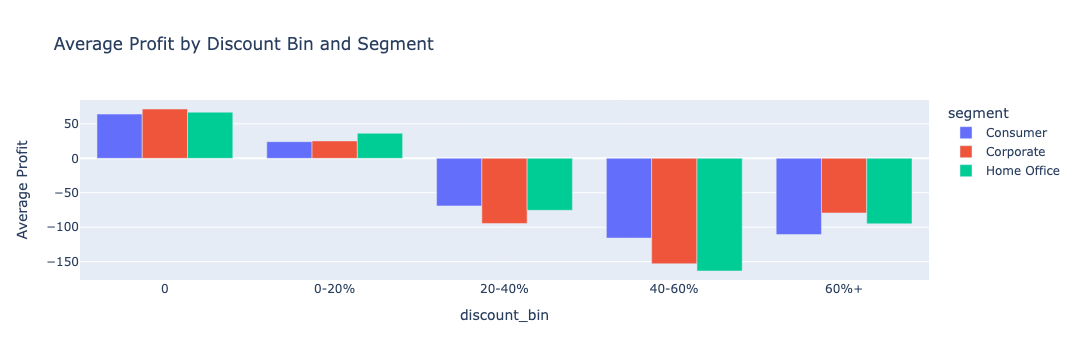

In [40]:
fig = px.bar(
    seg_discount_profit,
    x="discount_bin",
    y="profit",
    color="segment",
    barmode="group",
    labels={"profit": "Average Profit"},
    title="Average Profit by Discount Bin and Segment"
)
fig.show()


In [41]:
profit_by_region = (
    df_eda
    .groupby("region", as_index=False)["profit"]
    .sum()
    .sort_values("profit", ascending=False)
)

profit_by_region


,region,profit
3,West,108417.4781
1,East,91522.7800
2,South,46749.4303
0,Central,39704.3625


In [52]:
state_map = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT",
    "Delaware": "DE", "Florida": "FL", "Georgia": "GA",
    "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL",
    "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME",
    "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI",
    "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO",
    "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM",
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND",
    "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR",
    "Pennsylvania": "PA", "Rhode Island": "RI",
    "South Carolina": "SC", "South Dakota": "SD",
    "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA",
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY",
    "District of Columbia": "DC"
}

profit_by_state["state_code"] = profit_by_state["state"].map(state_map)



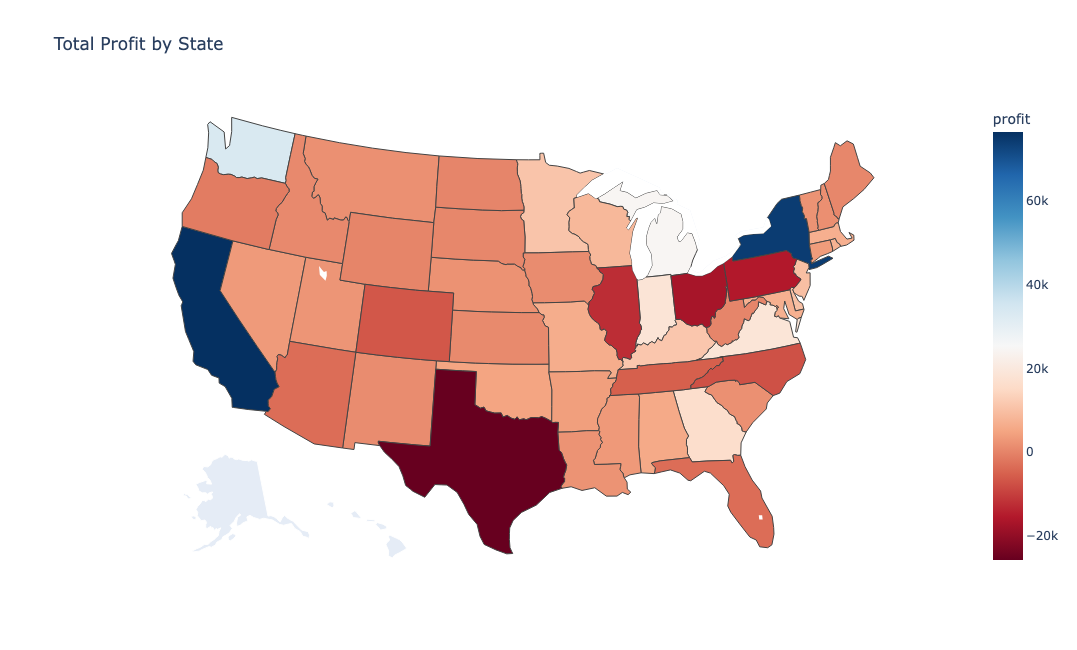

In [56]:
fig = px.choropleth(
    profit_by_state,
    locations="state_code",
    locationmode="USA-states",
    color="profit",
    scope="usa",
    color_continuous_scale="RdBu",
    title="Total Profit by State"
)

fig.update_layout(
    width=1100,
    height=650
)

fig.show()


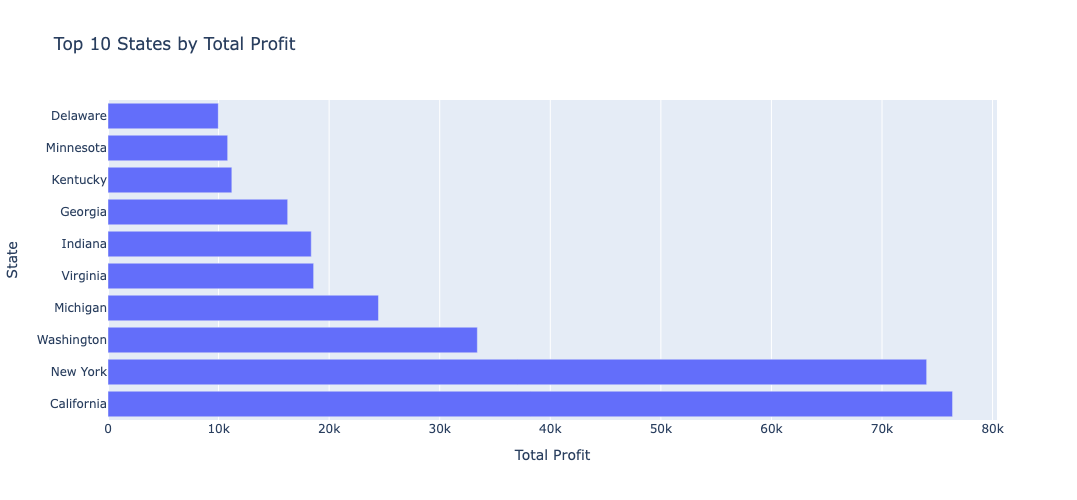

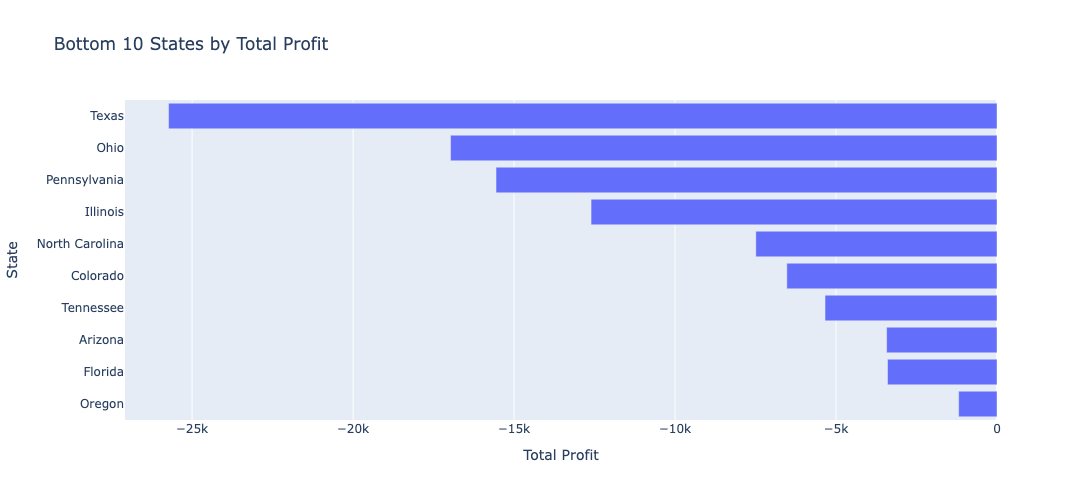

In [57]:
import plotly.express as px

top10 = profit_by_state.head(10)
bottom10 = profit_by_state.tail(10)

fig_top = px.bar(
    top10,
    x="profit",
    y="state",
    orientation="h",
    title="Top 10 States by Total Profit",
    labels={"profit": "Total Profit", "state": "State"}
)
fig_top.update_layout(height=500)
fig_top.show()

fig_bottom = px.bar(
    bottom10,
    x="profit",
    y="state",
    orientation="h",
    title="Bottom 10 States by Total Profit",
    labels={"profit": "Total Profit", "state": "State"}
)
fig_bottom.update_layout(height=500)
fig_bottom.show()


In [58]:
region_summary = (
    df_eda.groupby("region", as_index=False)
    .agg(
        total_sales=("sales", "sum"),
        total_profit=("profit", "sum"),
        avg_profit_margin=("profit_margin", "mean"),
        orders=("raw_id", "count") if "raw_id" in df_eda.columns else ("profit", "count")
    )
    .sort_values("total_profit", ascending=False)
)

region_summary


,region,total_sales,total_profit,avg_profit_margin,orders
3,West,725457.8245,108417.4781,0.219478,3203
1,East,678781.2400,91522.7800,0.167227,2848
2,South,391720.9050,46749.4303,0.163521,1620
0,Central,501239.8908,39704.3625,-0.104082,2323


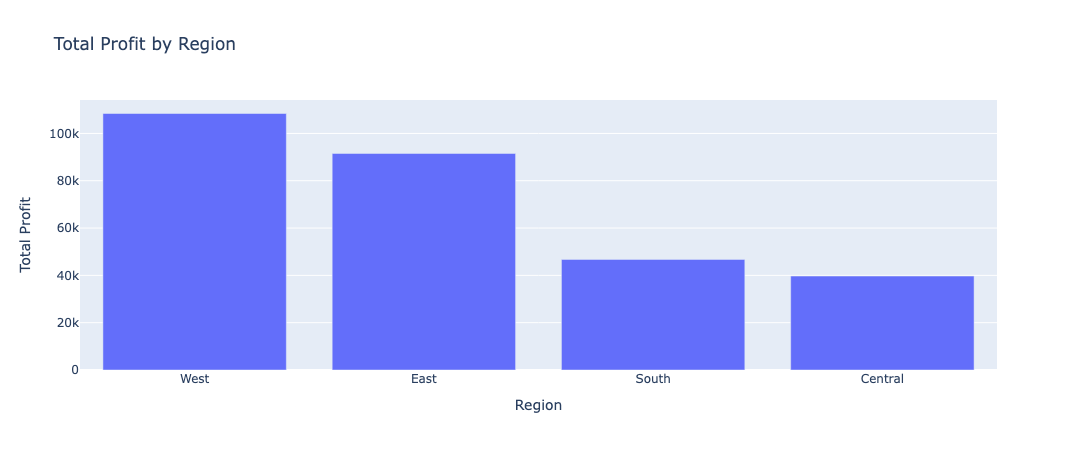

In [59]:
fig = px.bar(
    region_summary,
    x="region",
    y="total_profit",
    title="Total Profit by Region",
    labels={"total_profit": "Total Profit", "region": "Region"}
)
fig.update_layout(height=450)
fig.show()


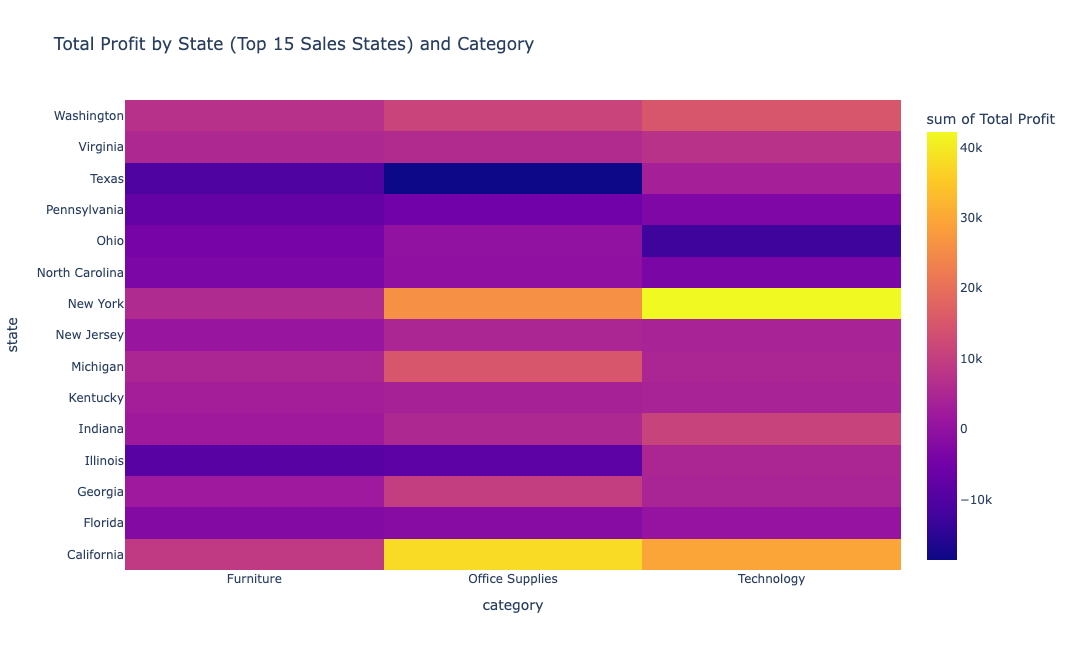

In [61]:
state_cat = (
    df_eda.groupby(["state", "category"], as_index=False)["profit"]
    .sum()
)

top_states = (
    df_eda.groupby("state", as_index=False)["sales"]
    .sum()
    .sort_values("sales", ascending=False)
    .head(15)["state"]
)

state_cat_15 = state_cat[state_cat["state"].isin(top_states)]

fig = px.density_heatmap(
    state_cat_15,
    x="category",
    y="state",
    z="profit",
    histfunc="sum",
    title="Total Profit by State (Top 15 Sales States) and Category",
    labels={"profit": "Total Profit"}
)
fig.update_layout(height=650)
fig.show()


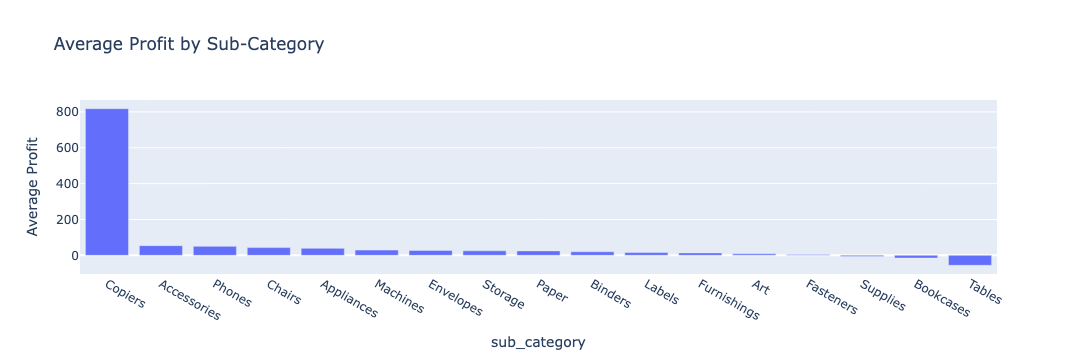

In [71]:
profit_by_subcat = (
    df_eda
    .groupby("sub_category", as_index=False)["profit"]
    .mean()
    .sort_values("profit", ascending=False)
)

fig = px.bar(
    profit_by_subcat,
    x="sub_category",
    y="profit",
    labels={"profit": "Average Profit"},
    title="Average Profit by Sub-Category"
)
fig.show()


In [62]:
profit_by_segment = (
    df_eda
    .groupby("segment", as_index=False)["profit"]
    .sum()
    .sort_values("profit", ascending=False)
)

profit_by_segment


,segment,profit
0,Consumer,134116.2384
1,Corporate,91979.1340
2,Home Office,60298.6785


In [70]:
profit_by_product = (
    df_eda
    .groupby("sub_category", as_index=False)["profit"]
    .sum()
    .sort_values("profit", ascending=False)
)

profit_by_product.head(10)
profit_by_product.tail(10)


,sub_category,profit
1,Appliances,18138.0054
9,Furnishings,13059.1436
7,Envelopes,6964.1767
2,Art,6527.7870
10,Labels,5546.2540
11,Machines,3384.7569
8,Fasteners,949.5182
15,Supplies,-1189.0995
4,Bookcases,-3472.5560
16,Tables,-17725.4811


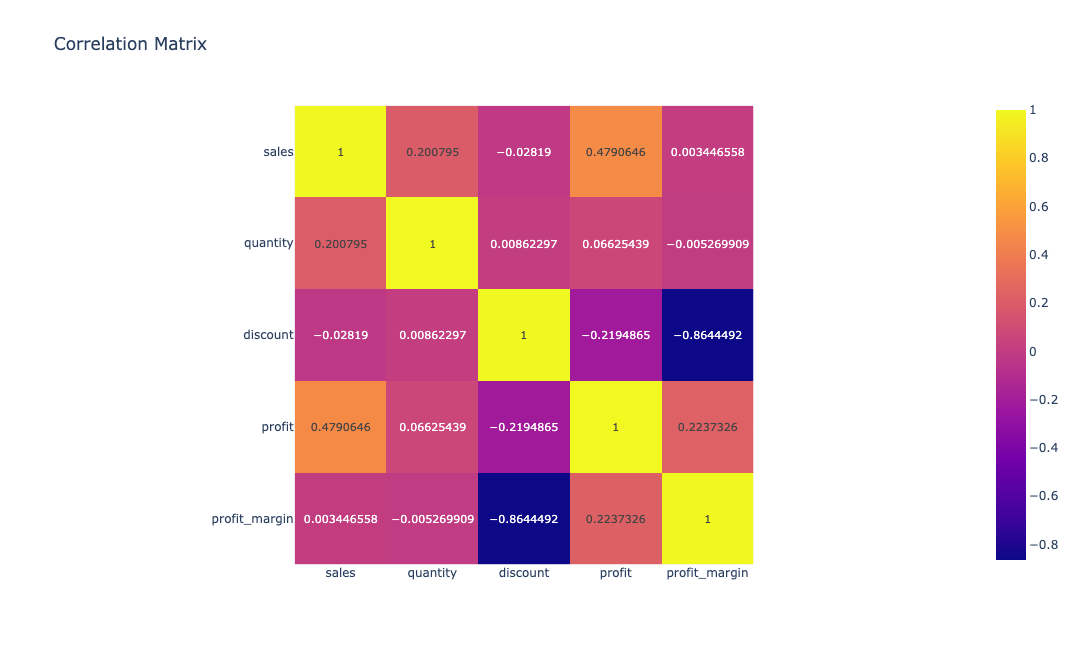

In [74]:
corr_cols = ["sales", "quantity", "discount", "profit", "profit_margin"]
corr = df_eda[corr_cols].corr()

fig = px.imshow(
    corr,
    text_auto=True,
    title="Correlation Matrix"
)

fig.update_layout(
    width=1100,
    height=650
)

fig.show()


# EDA Summary (to be used for modeling decisions):
# - High discounts strongly correlate with negative profit
# - Technology category shows highest average profitability
# - Profitability varies significantly by state and segment
# - Outliers exist but will be handled during preprocessing
### “Outliers were identified during EDA. Since they represent valid business cases, they were not removed and will be handled during preprocessing or modeling using robust techniques.”


### Handling Outliers & Modeling Strategy

Based on the exploratory data analysis (EDA), several outliers were identified, particularly in the `profit` variable. These outliers reflect valid business scenarios such as high discounts, large transactions, and significant losses, rather than data quality issues. Therefore, they were not removed during the EDA phase.

For the modeling stage, the following strategy will be applied:

- Outliers will be retained to preserve real-world business behavior.
- A baseline model will be used as an initial benchmark to understand model behavior in the presence of extreme values.
- Model performance will be evaluated using MAE and RMSE to assess sensitivity to large errors.
- Based on baseline performance, more robust models (e.g., tree-based models) or feature transformations may be explored if necessary.

The baseline model is intended to establish a reference point and validate the end-to-end modeling pipeline, rather than to achieve optimal predictive performance.


In [75]:
TARGET = "profit_margin"

In [76]:
NUM_COLS = ["sales", "quantity", "discount"]
CAT_COLS = ["segment", "region", "category", "sub_category", "ship_mode"]


In [77]:
X = df_eda[NUM_COLS + CAT_COLS].copy()
y = df_eda[TARGET].copy()


In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [80]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUM_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS)
    ]
)


In [82]:
dummy_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DummyRegressor(strategy="mean"))
])

dummy_model.fit(X_train, y_train)
dummy_pred = dummy_model.predict(X_test)


In [83]:
ridge_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0))
])

ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)


In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

dummy_metrics = evaluate(y_test, dummy_pred)
ridge_metrics = evaluate(y_test, ridge_pred)

dummy_metrics, ridge_metrics


({'MAE': 0.29278953291205007,
  'RMSE': 0.4641143303430919,
  'R2': -0.0004467124670921585},
 {'MAE': 0.15008030658586988,
  'RMSE': 0.20051394442128886,
  'R2': 0.8132618011315458})

### Model Extension: Random Forest Regression

After establishing a strong linear baseline using Ridge regression, a tree-based model is introduced as the next step. Random Forest regression is selected due to its robustness to outliers and its ability to capture non-linear relationships observed during EDA, particularly in discount-related behavior.

The goal of this step is to evaluate whether a more flexible model can further improve predictive performance compared to the linear baseline, while maintaining generalization and stability.


In [85]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Random Forest (tree-based baseline extension)
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_metrics = evaluate(y_test, rf_pred)
rf_metrics


{'MAE': 0.06088899183529749,
 'RMSE': 0.0958076112830875,
 'R2': 0.9573671830421232}

In [86]:
import pandas as pd

results = pd.DataFrame([
    {"model": "Dummy(mean)", **dummy_metrics},
    {"model": "Ridge", **ridge_metrics},
    {"model": "RandomForest", **rf_metrics},
]).sort_values("RMSE")

results


,model,MAE,RMSE,R2
2,RandomForest,0.060889,0.095808,0.957367
1,Ridge,0.150080,0.200514,0.813262
0,Dummy(mean),0.292790,0.464114,-0.000447
